In [53]:
import pandas as pd
import os
import tarfile
from PIL import Image
import torchvision 
import torch.nn as nn
from torch.utils.data import TensorDataset, Dataset, DataLoader
from datetime import datetime
import torch

import matplotlib.pyplot as plt

In [54]:
#Reading solar images
solar_Images=[f for f in os.listdir("img") if f.endswith(".jpg")]

#Loading images
images=[]
for i in range(len(solar_Images)):
    if i<400:
        imageFilePath=solar_Images[i]
        image=Image.open("img\\"+imageFilePath)
        image=image.resize((64,64))
        images.append(image)
        

In [55]:
#Reading flare dataset.
flareDataset=pd.read_csv('flareDataset.csv')
num_Rows, num_Columns=flareDataset.shape

#Setting everything to a universal time scale, with the 0 of time being the first image. 
initial_Time_Split=solar_Images[0].split("_")
date=initial_Time_Split[0]
time=initial_Time_Split[1]
s=""
s+=(f"{date[:4]}-{date[4:6]}-{date[6:]}")
s+=" "
s+=f"{time[:2]}:{time[2:4]}:{time[4:]}"
t0=datetime.strptime(s, '%Y-%m-%d %H:%M:%S')

deltat_Images=[]

for imageName in solar_Images:
    s_split=imageName.split("_")
    s="" 
    date=s_split[0]
    time=s_split[1]
    s+=(f"{date[:4]}-{date[4:6]}-{date[6:]}")
    s+=" "
    s+=f"{time[:2]}:{time[2:4]}:{time[4:]}"
    t=datetime.strptime(s, '%Y-%m-%d %H:%M:%S')
    deltat_Images.append((t-t0).total_seconds()/3600)
    
deltat_Flares=[]
for i in range(num_Rows):
    s_split=flareDataset.loc[i, "T_REC"].split(" ")
    s="" 
    date=s_split[0]
    time=s_split[1]
    s+=date
    s+=" "
    s+=time
    t=datetime.strptime(s, '%Y-%m-%d %H:%M:%S')
    flareDataset.loc[i, "T_REC"]=(t-t0).total_seconds()/3600
    
for i in range(num_Rows):
    if int(flareDataset.loc[i,"T_REC"])<0 or int(flareDataset.loc[i, "FlareNumber"]) !=1:
        flareDataset.drop(i, inplace=True)
   
flareDataset.reset_index(drop=True, inplace=True)

num_Rows, num_Columns=flareDataset.shape

#Normalizing flare database for gradient descent, and dropping any values that will not be useful.
flareDataset.drop("FlareNumber", axis=1, inplace=True)
flareDataset.drop("NOAA_AR", axis=1, inplace=True)
flareDataset.drop("QUALITY", axis=1, inplace=True)
flareDataset.drop("MEANPOT", axis=1, inplace=True)

means=[]
stds=[]

for col in flareDataset:
    if col!="T_REC":
        mean=flareDataset[col].mean()
        std=flareDataset[col].std()
        means.append(mean)
        stds.append(std)
        for i in range(num_Rows):
            flareDataset.loc[i, col]-=mean
            flareDataset.loc[i, col]/=std
        

C:\Users\Shiyan Liu\AppData\Local\Temp\ipykernel_21048\83276098.py:64: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '12.573684210526316' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  flareDataset.loc[i, col]-=mean
C:\Users\Shiyan Liu\AppData\Local\Temp\ipykernel_21048\83276098.py:64: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '-2.1657894736842103' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  flareDataset.loc[i, col]-=mean


In [56]:
def attachActualValues():
    pointer1 = 0
    pointer2 = 0
    solarFlareDates = flareDataset.T_REC.array
    newData = []

    for tensor in images:
        while(deltat_Images[pointer1] > solarFlareDates[pointer2]):
            pointer2 += 1

        dateOfImage = deltat_Images[pointer1]
        dateOfNextSolarFlare = solarFlareDates[pointer2]
        dateToNextFlare = dateOfNextSolarFlare-dateOfImage

        newData.append(dateToNextFlare)
        pointer1 += 1

    return newData

predictedValues=attachActualValues()
print(predictedValues)

[1574.536111111111, 1466.0594444444444, 1329.7227777777778, 1147.6461111111112, 1014.6827777777777, 913.406111111111, 793.5594444444444, 688.7927777777777, 575.436111111111, 459.7361111111111, 314.4561111111111, 202.816111111111, 81.2594444444444, 1638.872777777778, 1433.4794444444447, 1261.1994444444447, 1101.4394444444447, 881.2194444444444, 433.21944444444443, 322.992777777778, 217.63277777777785, 99.62611111111119, 2810.8027777777775, 2705.3927777777776, 2358.056111111111, 1658.4427777777773, 1285.6494444444443, 1183.3994444444443, 1057.8994444444443, 950.8027777777779, 726.0727777777774, 523.5194444444442, 297.64944444444427, 80.55944444444413, 99.24277777777752, 15.199444444444453, 161.0327777777784, 10.999444444444634, 353.01944444444507, 102.26944444444507, 2457.0627777777772, 2356.5727777777774, 2231.299444444444, 2128.592777777777, 2010.549444444444, 1909.1294444444438, 1798.8194444444434, 1692.59611111111, 1571.0494444444448, 1463.895555555555, 1360.8327777777777, 1254.41944

C:\Users\Shiyan Liu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torchvision\models\_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
C:\Users\Shiyan Liu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


17.486351479489255
35.54036913907432
34.36316715531972
22.337605992877922
46.51893702285244
33.94380280893619
9.617009444714204
38.20889562472476
21.22772525364987
21.323854247828624
44.045118222523946
28.48594393268566
40.0653654288145
26.53250450999522
18.241092081374422
21.234852137759283
23.623812708996027
20.62366893853058
24.86773606251683
27.83167156809496
25.8035120634581
23.91130915059104
39.76355082180581
16.328595155378917
37.12847790480749
30.90477014488756
22.70311006442118
34.95622572609762
30.766478054450758
25.114849041177038
28.00927290183705
18.47032741430608
32.8399488364908
44.58608100956695
45.38143463328368
25.918879276531015
23.33357165986918
39.411519935747634
20.286450978817665
24.02943931915715
35.33283890672151
33.255220976896574
18.006335238575293
28.10320239419394
43.20821279314591
41.119516900601944
20.022252567412686
22.450461476016727
33.32710553801015
24.91112457526088
37.36078324928427
49.93359305395294
21.968547493929943
28.87538705248045
34.271963633

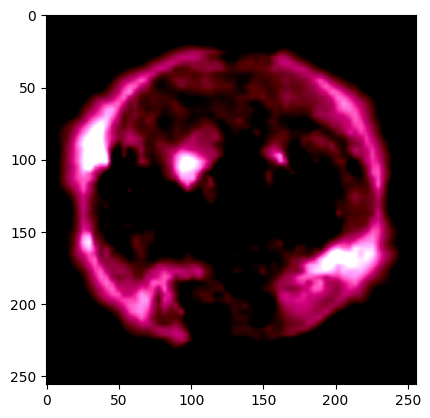

In [59]:
import torchvision.transforms as transforms
import numpy as np
#Defining custom dataset class.

class CustomDataset(Dataset):
    def __init__(self, data, transform=None):
        self.data = data
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        tensor, label = self.data[index]
        if self.transform:
            tensor=self.transform(tensor)
        return tensor, label
    
#Residual neural network for regression.
resnet=torchvision.models.resnet18(torchvision.models.ResNet18_Weights.DEFAULT)
resnet.float()

for param in resnet.parameters():
    param=param.to(dtype=torch.float32)
    
transform_train=transforms.Compose([
    transforms.Resize(256),      # Resize the input image to 256x256 pixels
    transforms.ToTensor(),      # Convert the image to a PyTorch tensor
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],  # Mean values for each channel
        std=[0.229, 0.224, 0.225]   # Standard deviation values for each channel
    )
])
tensor_Transform=torchvision.transforms.ToTensor()

#Transform it, then greyscale it.
arr=[(image, label) for image, label in zip(images, predictedValues)]

plt.imshow(transform_train(arr[predictedValues.index(max(predictedValues))][0]).permute(1,2,0))
inputs=CustomDataset(arr, transform=transform_train)

#print(transform_train(ToTensor(images[0])))

#Replacing classification layer with regression layer.
num_In=resnet.fc.in_features
resnet.fc=nn.Sequential(
    nn.Linear(num_In, 256),  
    nn.ReLU(inplace=True), 
    nn.Dropout(0.25),
    nn.Linear(256, 256),
    nn.ReLU(inplace=True),
    nn.Dropout(p=0.25),
    nn.Linear(256, 1),
    #nn.Softmax(dim=1)
    #nn.Dropout(0.25),  
    #nn.ReLU(inplace=True), 
    #nn.Dropout(0.25),  
    #nn.Linear(256, 10),
    #nn.ReLU(inplace=True), 
    #nn.Dropout(0.25),  
    #nn.Linear(128, 10)
)
    
dataLoader=DataLoader(inputs, batch_size=8, shuffle=True)

num_Epochs=20
n=0

#Initializing model.
optimizer = torch.optim.Adam(resnet.parameters(), lr=0.00001)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)
loss_Function= nn.MSELoss()

losses=[]

for n in range(num_Epochs):
    avg_loss=0
    count=0
    for batch in dataLoader:
        if count<len(dataLoader)/2:
            if len(batch[0])==dataLoader.batch_size:
                image, label=batch
                
                outputs = resnet(image) # Forward pass
                loss = loss_Function(outputs, label.to(dtype=torch.float32))  
                    
                lossDays=(loss.item())**(1/2)/24
                losses.append(lossDays)
                optimizer.zero_grad()
                print(lossDays) #Average days
                
                loss.backward()  # Backpropagation
                optimizer.step()  # Update weights
        count+=1
    scheduler.step()    

print(losses)

In [66]:
%store losses

Stored 'losses' (list)
